# Clustering Analysis of Transaction Data

## Introduction

This notebook performs a clustering analysis on a dataset containing transaction information. The main goal is to group similar transactions together to uncover patterns and insights. The steps followed in this analysis include:

1. **Data Preprocessing**: Cleaning and preparing the data for analysis.
2. **Feature Engineering**: Creating new features from existing data to improve the clustering results.
3. **Standardization**: Scaling the data to ensure uniformity in clustering.
4. **Clustering**: Using K-Means clustering to identify groups within the data.
5. **Visualization**: Reducing dimensionality using PCA for easy visualization of clusters.
6. **Cluster Analysis**: Analyzing the characteristics of each cluster.

The dataset includes various features such as transaction date, amount, merchant name, and categorical codes related to the transactions. By the end of this notebook, you will have a clear understanding of the different transaction patterns and how they are grouped.

## Libraries and Tools Used

- **pandas**: For data manipulation and analysis.
- **numpy**: For numerical operations.
- **scikit-learn**: For standardization, clustering, and PCA.
- **matplotlib**: For creating static, animated, and interactive visualizations.
- **seaborn**: For making statistical graphics.

Let's start by importing the necessary libraries and loading the dataset.


In [8]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import glob

## Data Loading and Preparation

In this section, we will load the transaction data from multiple Excel files. The files are organized by year and some files do not include the year in their filenames. To manage this, we will use a custom function `read_transactions_files` which will help in reading and combining all the relevant files into a single DataFrame for further analysis.

### Explanation of the Function `read_transactions_files`

The function `read_transactions_files` takes two parameters:
- `years`: A list of years to include in the file search patterns.
- `files_without_year`: A list of specific files that do not have a year in their filenames.

Here's a step-by-step explanation of what the function does:

1. **File Patterns Creation**:
    - The function creates a list of file patterns using the provided `years`. It generates a pattern for each year that looks for files containing that year in their name within the 'Datasets' directory.
    - It also extends this list with any additional files provided in `files_without_year`.

2. **Combine Files into One DataFrame**:
    - The function uses the `glob` module to find all files matching the patterns.
    - It then reads each file into a DataFrame, ensuring that any variations in column names (like 'Directorate ') are standardized.
    - All these DataFrames are concatenated into a single DataFrame.

In [9]:
years=[2014, 2015, 2016]
files_without_year = ['Datasets/publishspendpurchasecardsfebruary.xls', 'Datasets/publishspendpurchasecardsmarch.xls']
def read_transactions_files(years, files_without_year=[]):

    # add files that doesn't have a year in the name
    file_patterns = [f'Datasets/*{year}*.xls'for year in years]
    if len(files_without_year) > 0:
        file_patterns.extend(files_without_year)
    
    # Combine all the files into one DataFrame
    all_excel_files = []
    for pattern in file_patterns:
        all_excel_files.extend(glob.glob(pattern))
    df_list = [pd.read_excel(file).rename(columns={'Directorate ':'Directorate', 'Directorates':'Directorate', 'Unnamed: 10':'Directorate'}) for file in all_excel_files]
    data = pd.concat(df_list, ignore_index=True)
    return data

df = read_transactions_files(years, files_without_year)

In [10]:
# we have one column with the same values
df['BILLING CUR CODE'].value_counts()

BILLING CUR CODE
GBP    34467
Name: count, dtype: int64

In [11]:
# we drop the column
df.drop('BILLING CUR CODE', axis=1, inplace=True)

In [12]:
# check for percentage of nulls in each column
pd.DataFrame(df.isnull().sum()/len(df)*100).reset_index().rename(columns={'index':'column', 0:'null (%)'})

,column,null (%)
0,TRANS DATE,0
1,TRANS VAT DESC,4
2,ORIGINAL GROSS AMT,0
3,MERCHANT NAME,0
4,CARD NUMBER,0
5,TRANS CAC CODE 1,0
6,TRANS CAC DESC 1,0
7,TRANS CAC CODE 2,0
8,TRANS CAC DESC 2,0
9,TRANS CAC CODE 3,0


In [13]:
# we drop the rows with missing values as they are a small percentage
df.dropna(inplace=True)

## Data Preprocessing and Clustering Analysis

In this section, we will preprocess the transaction data and perform clustering analysis to identify patterns and group similar transactions together.

### Step-by-Step Explanation

1. **Convert Transaction Date to Datetime Format**:
    - Convert the transaction dates to the correct datetime format to allow for accurate date calculations and sorting. This ensures consistency and correctness in date-related operations.

2. **Calculate Total Gross Amount and Total Number of Transactions**:
    - Calculate the total gross amount and the total number of transactions for each card by grouping the data by card number. This provides an overview of the spending and transaction frequency for each card.

3. **Sort the Data by Card Number and Transaction Date**:
    - Sort the data by card number and transaction date to help in calculating the time difference between consecutive transactions for each card. Sorting is essential for accurate time difference calculations.

4. **Calculate Time Difference Between Transactions**:
    - Calculate the time difference in days between consecutive transactions for each card to understand the transaction frequency. This helps in identifying how frequently transactions are made.

5. **Calculate Average Time to Next Transaction per Card**:
    - For each card, calculate the average time to the next transaction. This metric provides insight into the typical transaction interval for each card, helping to identify spending patterns.

6. **Merge the Results**:
    - Merge the total gross amount, total number of transactions, and the average time to the next transaction into a single DataFrame for each card. This consolidated view combines all relevant metrics for further analysis.

7. **Standardize the Data for Clustering**:
    - Standardize the data to ensure that all features contribute equally to the clustering process. Standardization scales the data so that features with larger ranges do not dominate the clustering algorithm.

8. **Determine the Optimal Number of Clusters Using the Elbow Method**:
    - Use the Elbow method to determine the optimal number of clusters by plotting the within-cluster sum of squares (WCSS) against the number of clusters. The "elbow" point in the plot indicates the optimal number of clusters.

9. **Apply K-Means Clustering**:
    - Apply K-Means clustering with the optimal number of clusters determined from the Elbow method. Assign cluster labels to each card to identify groups of similar transaction behaviors.

10. **Visualize the Clusters Using PCA**:
    - Use Principal Component Analysis (PCA) to reduce the dimensionality of the data for visualization. Plot the clusters to visually inspect the distribution and separation of different groups.

11. **Display the Characteristics of Each Cluster**:
    - Summarize and display the characteristics of each cluster, providing insights into the transaction patterns for different groups of cards. This analysis helps in understanding the distinct features and behaviors of each cluster.


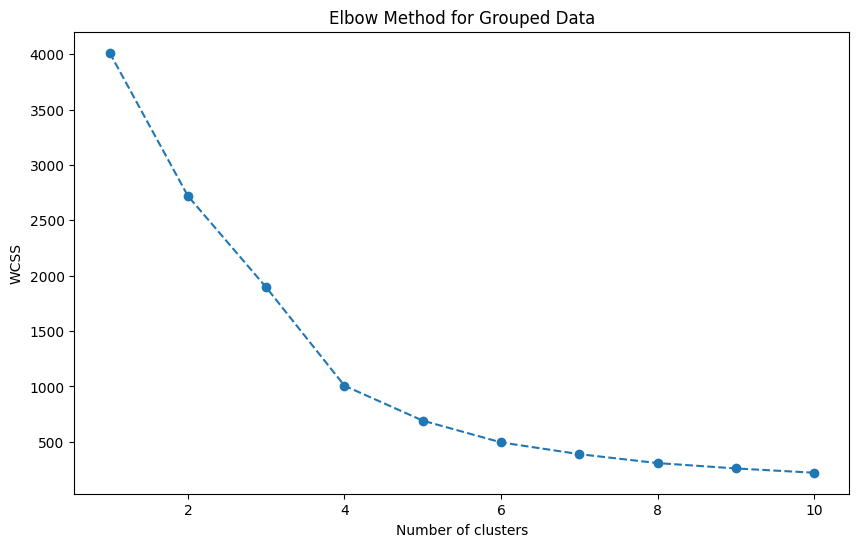

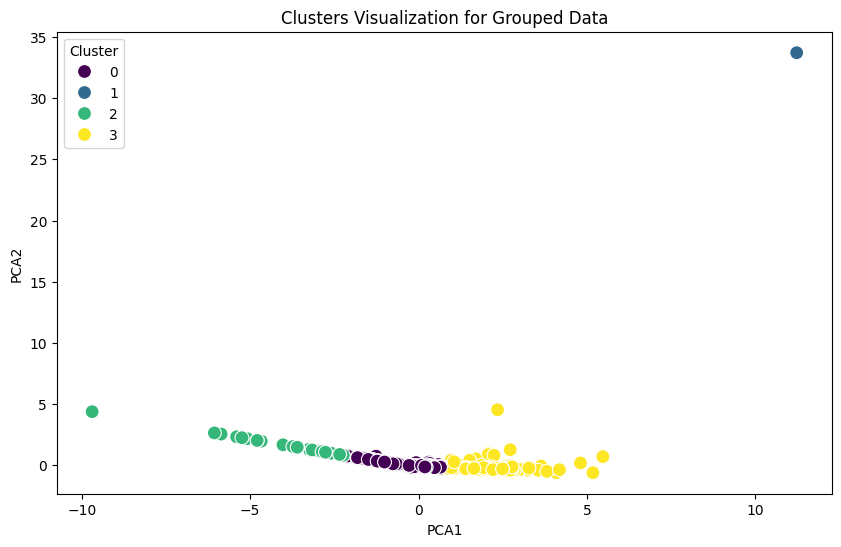

,total_gross_amt,total_transactions,avg_days_to_next_transaction,PCA1,PCA2
Cluster,,,,,
0,4349,53,19,-0,-0
1,6201711,223,4,11,34
2,543,5,182,-4,2
3,37025,328,3,2,-0


In [14]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
# Set a random seed for reproducibility
np.random.seed(42)

# Convert TRANS DATE to datetime
df['TRANS DATE'] = pd.to_datetime(df['TRANS DATE'])

# Calculate the total gross amount and total number of transactions
grouped_data = df.groupby('CARD NUMBER').agg(
    total_gross_amt=('ORIGINAL GROSS AMT', 'sum'),
    total_transactions=('ORIGINAL GROSS AMT', 'count')
).reset_index()

# Sort the data by CARD NUMBER and TRANS DATE
df = df.sort_values(by=['CARD NUMBER', 'TRANS DATE'])

# Calculate the time difference between transactions
df['time_diff'] = df.groupby('CARD NUMBER')['TRANS DATE'].diff().dt.days

# Calculate the average time to the next transaction per card
avg_time_diff = df.groupby('CARD NUMBER')['time_diff'].mean().reset_index()
avg_time_diff.rename(columns={'time_diff': 'avg_days_to_next_transaction'}, inplace=True)

# Merge the results
final_data = grouped_data.merge(avg_time_diff, on='CARD NUMBER')

# Standardize the grouped data for clustering
scaler = StandardScaler()
grouped_scaled_data = scaler.fit_transform(final_data[['total_gross_amt', 'total_transactions', 'avg_days_to_next_transaction']].fillna(0))

# Determine the optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(grouped_scaled_data)
    wcss.append(kmeans.inertia_)

# Plot the Elbow method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Grouped Data')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Apply K-Means clustering with the optimal number of clusters
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(grouped_scaled_data)

# Add cluster labels to the original grouped data
final_data['Cluster'] = clusters

# Use PCA for dimensionality reduction to visualize clusters
pca = PCA(n_components=2)
principal_components = pca.fit_transform(grouped_scaled_data)
final_data['PCA1'] = principal_components[:, 0]
final_data['PCA2'] = principal_components[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=final_data, palette='viridis', s=100)
plt.title('Clusters Visualization for Grouped Data')
plt.show()

# Display the characteristics of each cluster
cluster_summary_grouped = final_data.groupby('Cluster').mean(numeric_only=True)
cluster_summary_grouped

## Cluster Summary

The clustering analysis resulted in four distinct clusters, each representing a group of customers with similar transaction patterns. Below is a detailed summary of each cluster:

### Cluster 0:

- **Total Gross Amount**: 4,349
- **Total Transactions**: 53
- **Average Time to Next Transaction**: 19 days

**Interpretation**:
Cluster 0 represents customers who have made a moderate number of transactions (53) with a total gross amount of 4,349. On average, these customers take 19 days between transactions, indicating relatively infrequent but consistent spending behavior.

### Cluster 1:

- **Total Gross Amount**: 6,201,711
- **Total Transactions**: 223
- **Average Time to Next Transaction**: 4 days

**Interpretation**:
Cluster 1 consists of high-value customers with a significantly large total gross amount of 6,201,711 and a high number of transactions (223). The average time between transactions is 4 days, suggesting very frequent and high-volume spending.

### Cluster 2:

- **Total Gross Amount**: 543
- **Total Transactions**: 5
- **Average Time to Next Transaction**: 182 days

**Interpretation**:
Cluster 2 is characterized by a small number of transactions (5) with a low total gross amount of 543. The average time to the next transaction is 182 days, indicating very sporadic and low-volume spending behavior.

### Cluster 3:

- **Total Gross Amount**: 37,025
- **Total Transactions**: 328
- **Average Time to Next Transaction**: 3 days

**Interpretation**:
Cluster 3 represents customers with a high number of transactions (328) and a total gross amount of 37,025. These customers have a very short average time between transactions (3 days), indicating very frequent spending, although the total amount spent is moderate compared to Cluster 1.

## Overall Insights

The clustering analysis provides valuable insights into customer transaction behaviors:

- **Cluster 1** contains high-value, frequent spenders and is the most significant in terms of total gross amount.
- **Cluster 3** includes frequent but moderate spenders.
- **Cluster 0** consists of moderate, consistent spenders with less frequent transactions.
- **Cluster 2** captures low-value, infrequent spenders, which could represent a segment with less engagement or new customers.

These insights can be used for targeted marketing, personalized communication, and strategic decision-making to enhance customer engagement and increase transaction volumes.
